----------------------------------------------------------------------------------------------------------------------
# Bike-sharing Case Study

### Problem Statement: 
A bike-sharing system is a service in which bikes are made available for shared use to individuals on a short term basis for a price or free. Many bike share systems allow people to borrow a bike from a "dock" which is usually computer-controlled wherein the user enters the payment information, and the system unlocks it. This bike can then be returned to another dock belonging to the same system.

A US bike-sharing provider BoomBikes has recently suffered considerable dips in their revenues due to the ongoing Corona pandemic. 

Objective of this assignment is to understand the factors affecting the demand for these shared bikes in the American market and to know:

    - Which variables are significant in predicting the demand for shared bikes.
    - How well those variables describe the bike demands
    
#### Business Goal:
To model the demand for shared bikes with the available independent variables. This will be used by the management to understand how exactly the demands vary with different features. They can accordingly manipulate the business strategy to meet the demand levels and meet the customer's expectations. Further, the model will be a good way for management to understand the demand dynamics of a new market. 

----------------------------------------------------------------------------------------------------------------------

In [400]:
# Import the required libraries
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.graphics.gofplots import qqplot

pd.options.display.max_columns=999

----------------------------------------------------------------------------------------------------------------------
### Step 1: Data profiling (EDA)
          - 1. Load Data
          - 2. Understanding the data and Distinguish Attributes
          - 3. Data cleaning
          - 4. Univariate Analysis
          - 5. Bivariate Analysis
          - 6. Multi-variate Analysis
          - 7. Feature Engineering
          - 8. Collect Insight
----------------------------------------------------------------------------------------------------------------------

##### 1. Load data

In [401]:
bikesharing = pd.read_csv('day.csv')

#### day.csv file contains the following fields
    - instant: record index
	- dteday : date
	- season : season (1:spring, 2:summer, 3:fall, 4:winter)
	- yr : year (0: 2018, 1:2019)
	- mnth : month ( 1 to 12)
	- holiday : weather day is a holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
	- weekday : day of the week
	- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
	+ weathersit : 
		- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
		- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
		- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
		- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
	- temp : temperature in Celsius
	- atemp: feeling temperature in Celsius
	- hum: humidity
	- windspeed: wind speed
	- casual: count of casual users
	- registered: count of registered users
	- cnt: count of total rental bikes including both casual and registered

##### 2. Understanding the data 

In [402]:
bikesharing.shape

(730, 16)

In [403]:
bikesharing.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


#### 2.1 - Let us rename some of the columns which will be easier to understand
    - dteday = transaction_date
    - yr = year
    - mnth = month
    - weathersit = weather
    - atemp = actual_temp_felt
    - hum = humidity
    - cnt = count
    

In [404]:
bikesharing = bikesharing.rename(columns={'dteday':'transaction_date',
                                  'yr':'year',
                                  'mnth':'month',
                                  'weathersit':'weather',
                                  'atemp':'actual_temp_felt',
                                  'hum':'humidity',
                                  'cnt':'count'
                                 })
bikesharing.head()

,instant,transaction_date,season,year,month,holiday,weekday,workingday,weather,temp,actual_temp_felt,humidity,windspeed,casual,registered,count
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


#### 2.2. Get the basic statistical information

In [405]:
bikesharing.describe()

,instant,season,year,month,holiday,weekday,workingday,weather,temp,actual_temp_felt,humidity,windspeed,casual,registered,count
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,365.500000,2.498630,0.500000,6.526027,0.028767,2.997260,0.683562,1.394521,20.319259,23.726322,62.765175,12.763620,849.249315,3658.757534,4508.006849
std,210.877136,1.110184,0.500343,3.450215,0.167266,2.006161,0.465405,0.544807,7.506729,8.150308,14.237589,5.195841,686.479875,1559.758728,1936.011647
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.424346,3.953480,0.000000,1.500244,2.000000,20.000000,22.000000
25%,183.250000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,13.811885,16.889713,52.000000,9.041650,316.250000,2502.250000,3169.750000
50%,365.500000,3.000000,0.500000,7.000000,0.000000,3.000000,1.000000,1.000000,20.465826,24.368225,62.625000,12.125325,717.000000,3664.500000,4548.500000
75%,547.750000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,26.880615,30.445775,72.989575,15.625589,1096.500000,4783.250000,5966.000000
max,730.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,35.328347,42.044800,97.250000,34.000021,3410.000000,6946.000000,8714.000000


#### Observation:
   - There are no missing values
   - The target variable (dependent variable) count is in the range of 22 to 8714 <br>
      i.e the users rented between 22 to 8714 bikes a day. On an average 4508 bikes were rented per day.
   - The mean and 50% are almost equal which indicates there are not many outliers
     This we can further explore with other visualization.
   - This is only to understand the basic statistical data and as you know as per Anscombe’s quartet,
     we need to visualize the data before we can infer and not just rely on statistical data.

#### 2.3 Check the datatype of the variables

In [406]:
bikesharing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instant           730 non-null    int64  
 1   transaction_date  730 non-null    object 
 2   season            730 non-null    int64  
 3   year              730 non-null    int64  
 4   month             730 non-null    int64  
 5   holiday           730 non-null    int64  
 6   weekday           730 non-null    int64  
 7   workingday        730 non-null    int64  
 8   weather           730 non-null    int64  
 9   temp              730 non-null    float64
 10  actual_temp_felt  730 non-null    float64
 11  humidity          730 non-null    float64
 12  windspeed         730 non-null    float64
 13  casual            730 non-null    int64  
 14  registered        730 non-null    int64  
 15  count             730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory u

##### Observation:
  - There are no null / missing values
  - transaction_date is of type object. 
    Month and Year information is already available in the dataset. 
    Hence we can extract day from transaction_date and drop this column.
    So no further changes to this column required at this stage
  - There are categorical variables and we need to change the Dtype for these variables later.

#### 2.4 Handle missing values

In [407]:
bikesharing.isnull().sum()

instant             0
transaction_date    0
season              0
year                0
month               0
holiday             0
weekday             0
workingday          0
weather             0
temp                0
actual_temp_felt    0
humidity            0
windspeed           0
casual              0
registered          0
count               0
dtype: int64

 #### Observation:
 - As confirmed earlier, there are no null values

#### 2.5 Checking for duplicates

In [408]:
bikesharing_dup = bikesharing.copy()

# Checking for duplicates and dropping the entire duplicate row if any
bikesharing_dup.drop_duplicates(subset=None, inplace=True)

print("original data shape = ",bikesharing.shape)
print("Data shape after removing dupicates = ", bikesharing_dup.shape)

original data shape =  (730, 16)
Data shape after removing dupicates =  (730, 16)


#### Observation:
   - There are no duplicate rows in the dataset

#### 2.5 Handle the Outliers

In [409]:
bikesharing.apply(lambda x: len(x.unique()))

instant             730
transaction_date    730
season                4
year                  2
month                12
holiday               2
weekday               7
workingday            2
weather               3
temp                498
actual_temp_felt    689
humidity            594
windspeed           649
casual              605
registered          678
count               695
dtype: int64

#### Observation:
   - Categorical variables are : season, year, month, holiday, weekday, workingday, weather
   - Continuous Numerical variables are : temp, actual_temp_felt, humidity, windspeed, casual, registered, count

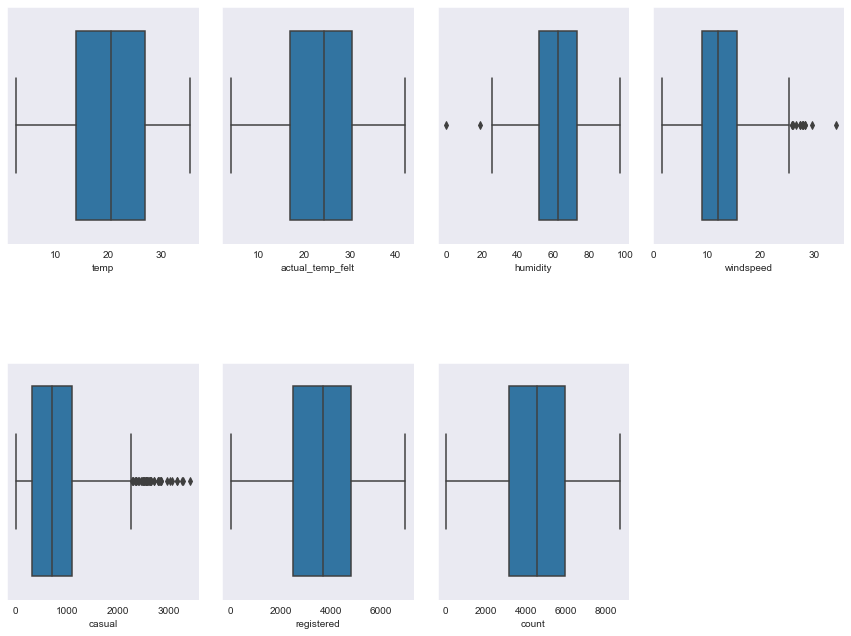

In [410]:
# Box plots for independent variables with continuous numerical values
def BoxPlots(xVars,data):
    len_xVars = len(xVars)
    cols = 4
    rows = math.ceil(len_xVars/cols)*2
    if rows <=2:
        hspace = 0.5
        plt.figure(figsize=(15,10))
    else:
        hspace = 0.5
        plt.figure(figsize=(15,15+(rows-1)**2))
    index = 1
    for x in xVars:
        plt.subplot(rows,cols,index)
        plt.subplots_adjust(hspace=hspace, wspace=0.125)
        sns.boxplot(x,data=bikesharing)
        index = index + 1
    plt.show()

cols = ['temp','actual_temp_felt','humidity','windspeed','casual','registered','count']

BoxPlots(cols,bikesharing)

#### Observation:
   - From these plots, we can see that there are no outliers to be handled. Since casual is part of count dependent variable and we will be dropping this post RFE we can ignore this for now.
   - In short, no further handling of outliers required in this dataset.

#### 3 - Cleaning the data:
 - instant is just an unique number for each record. We can set this as index or we can drop them.
   Choosing to drop this column
 - transaction_date is not required as we have year and month information. Drop the column
 - count is our target variable. casual and registered columns are part of dependent target variable.
    count = casual + registered
    We can drop the casual and registered columns now but prefer to drop them post RFE.

In [411]:
# dropping the transaction_date and instant column
bikesharing.drop(columns=['instant','transaction_date'],axis=1,inplace=True)
bikesharing.head()

,season,year,month,holiday,weekday,workingday,weather,temp,actual_temp_felt,humidity,windspeed,casual,registered,count
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [412]:
# weekday has values from 0 to 6. 
# Let us check if 0 is sunday or Monday
bikesharing.groupby('weekday').sum()["workingday"]

weekday
0      0
1     90
2    103
3    102
4    102
5    102
6      0
Name: workingday, dtype: int64

#### comment:
   - This means sunday is encoded as 0 and saturday as 6

In [413]:
# change the int values to category for categorical columns
cols = ['season','month','holiday','weekday','workingday','weather']
for col in cols:
    bikesharing[col] = bikesharing[col].astype('category')
bikesharing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   season            730 non-null    category
 1   year              730 non-null    int64   
 2   month             730 non-null    category
 3   holiday           730 non-null    category
 4   weekday           730 non-null    category
 5   workingday        730 non-null    category
 6   weather           730 non-null    category
 7   temp              730 non-null    float64 
 8   actual_temp_felt  730 non-null    float64 
 9   humidity          730 non-null    float64 
 10  windspeed         730 non-null    float64 
 11  casual            730 non-null    int64   
 12  registered        730 non-null    int64   
 13  count             730 non-null    int64   
dtypes: category(6), float64(4), int64(4)
memory usage: 51.3 KB


### change the values of some of the categorical variables for better representation during visualization

   - These variables are nominal but since they having numerical values, they could be considered as ordinal.
     Hence setting them to have the string values will help.

In [414]:
category_value_dict = {"season":{1:"spring", 2:"summer", 3:"fall", 4:"winter"},
                       "weather":{1:'good',2:'moderate',3:'bad',4:'severe'},
                       "weekday":{0:"Sunday",1:"Monday",2:"Tuesday",3:"Wednesday",4:"Thursday",5:"Friday",6:"Saturday"},
                       "month":{1:"January",2:"February",3:"March",4:"April",5:"May",6:"June",
                                7:"July",8:"August",9:"September",10:"October",11:"November",12:"December"},
                       "year":{0:"2018",1:"2019"}
                      }

for col in category_value_dict.keys():
    bikesharing[col] = bikesharing[col].apply(lambda x: category_value_dict[col][x])
    
bikesharing.head()

,season,year,month,holiday,weekday,workingday,weather,temp,actual_temp_felt,humidity,windspeed,casual,registered,count
0,spring,2018,January,0,Saturday,0,moderate,14.110847,18.18125,80.5833,10.749882,331,654,985
1,spring,2018,January,0,Sunday,0,moderate,14.902598,17.68695,69.6087,16.652113,131,670,801
2,spring,2018,January,0,Monday,1,good,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,spring,2018,January,0,Tuesday,1,good,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,spring,2018,January,0,Wednesday,1,good,9.305237,11.46350,43.6957,12.522300,82,1518,1600


#### 4 - Univariate Analysis

In [415]:
# This function plots distribution and box plots as subplots for specified feature in the dataset
# featureName - Variable name for which you want to draw the plots
# returns - None

def plot_Distribution_BoxPlot(featureName,xlabel,dataset=bikesharing):
    #dataset = removeOutliers(featureName)
    print(dataset[featureName].describe())
    plt.figure(figsize=(15,10),facecolor='c')
    sns.set_style("dark")
    # subplot 1
    plt.subplot(2, 2, 1)
    ax = sns.distplot(dataset[featureName],rug = True)
    ax.set_title(xlabel + ' - Distribution Plot',fontsize=16,color='w')
    ax.set_xlabel(xlabel,fontsize=14,color='w')
    ax.set_ylabel('Density',fontsize=14,color='w')
    # subplot 2
    plt.subplot(2, 2, 2)
    ax = sns.boxplot(y=dataset[featureName])
    ax.set_title(xlabel + ' - Box Plot',fontsize=16,color='w')
    ax.set_ylabel(xlabel,fontsize=14,color='w')
    plt.show()

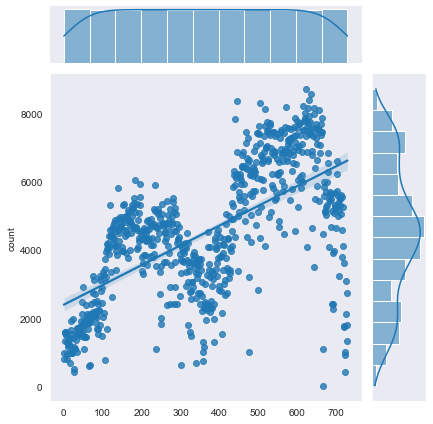

In [416]:
sns.jointplot(data=bikesharing,x=bikesharing.index, y=bikesharing['count'],kind='reg')
plt.show()

count     730.000000
mean     4508.006849
std      1936.011647
min        22.000000
25%      3169.750000
50%      4548.500000
75%      5966.000000
max      8714.000000
Name: count, dtype: float64


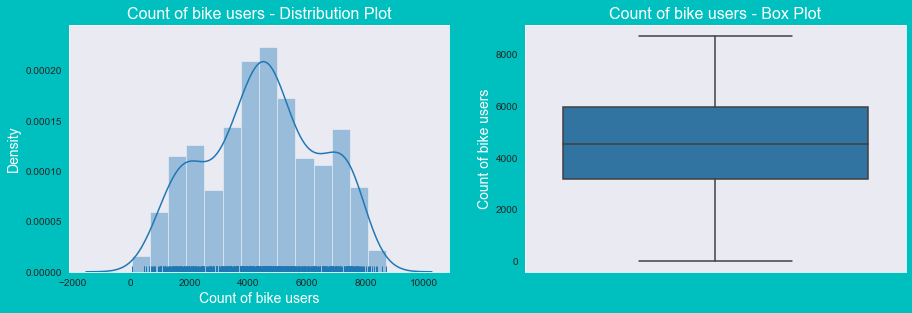

In [417]:
plot_Distribution_BoxPlot(featureName='count',xlabel='Count of bike users')

count    730.000000
mean      20.319259
std        7.506729
min        2.424346
25%       13.811885
50%       20.465826
75%       26.880615
max       35.328347
Name: temp, dtype: float64


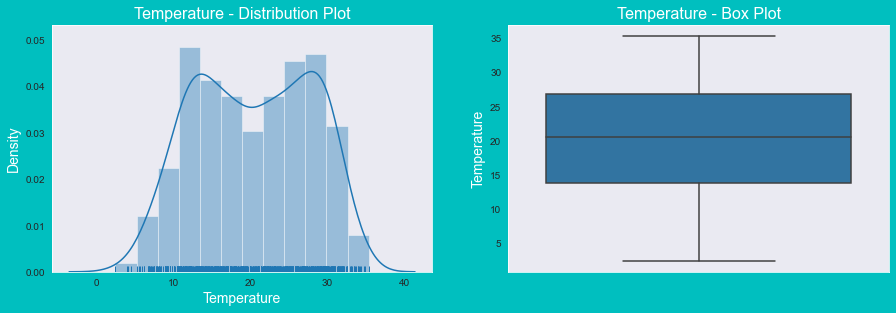

In [418]:
plot_Distribution_BoxPlot(featureName='temp',xlabel='Temperature')

count    730.000000
mean      62.765175
std       14.237589
min        0.000000
25%       52.000000
50%       62.625000
75%       72.989575
max       97.250000
Name: humidity, dtype: float64


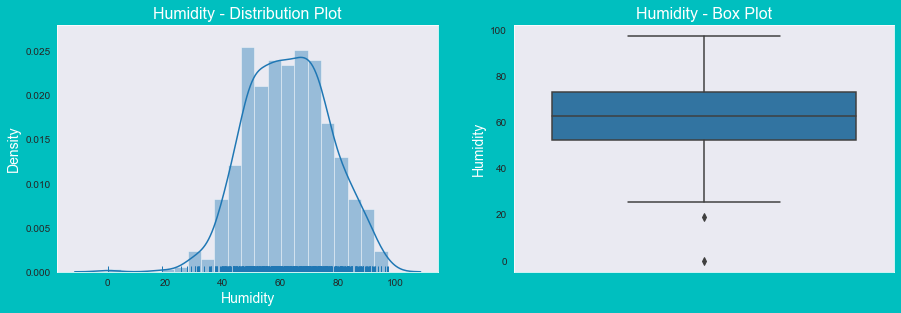

In [419]:
plot_Distribution_BoxPlot(featureName='humidity',xlabel='Humidity')

#### 5 - Bivariate Analysis

There are 7 categorical variables in the dataset. Let us Box plot to study their effect on the dependent variable ('count') .

In [420]:
def categoricalBoxPlots(xVars,y,data):
    len_xVars = len(xVars)
    cols = 2
    rows = math.ceil(len_xVars/cols)*2
    if rows <=2:
        hspace = 0.5
        plt.figure(figsize=(15,10))
    else:
        hspace = 0.5
        plt.figure(figsize=(20,20))
    index = 1
    for x in xVars:
        plt.subplot(rows,cols,index)
        plt.subplots_adjust(hspace=hspace, wspace=0.125)
        my_order = data.groupby(by=[x])[y].median().sort_values().iloc[::-1].index
        ax=sns.boxplot(x=x,y=y,data=data,order=my_order)
        index = index + 1
        ax1 = plt.subplot(rows,cols,index,title="Shared bike demand based on "+ x)
        plt.subplots_adjust(hspace=hspace, wspace=0.125)
        temp_df = (data.groupby(x).sum().sort_values(y,ascending=False)[y] / data.groupby(x).sum().sort_values(y,ascending=False)[y].sum())*100
        temp_df=temp_df.round(decimals=2)
        ax2 = temp_df.plot(kind='bar',ax=ax1)
        ax2.bar_label(ax2.containers[0],fmt='%.2f%%')
        #data.groupby(x).sum().sort_values(y,ascending=False)[y].plot.bar(ax=ax1)
        plt.setp(ax.get_xticklabels(), rotation=90)
        index = index + 1
    plt.show()

## Step 2: Visualising the Data

Let's now spend some time doing what is arguably the most important step - **understanding the data**.
- If there is some obvious multicollinearity going on, this is the first place to catch it
- Here's where you'll also identify if some predictors directly have a strong association with the outcome variable

We'll visualise our data using `matplotlib` and `seaborn`.

### 2.1 Visualising the numeric variables


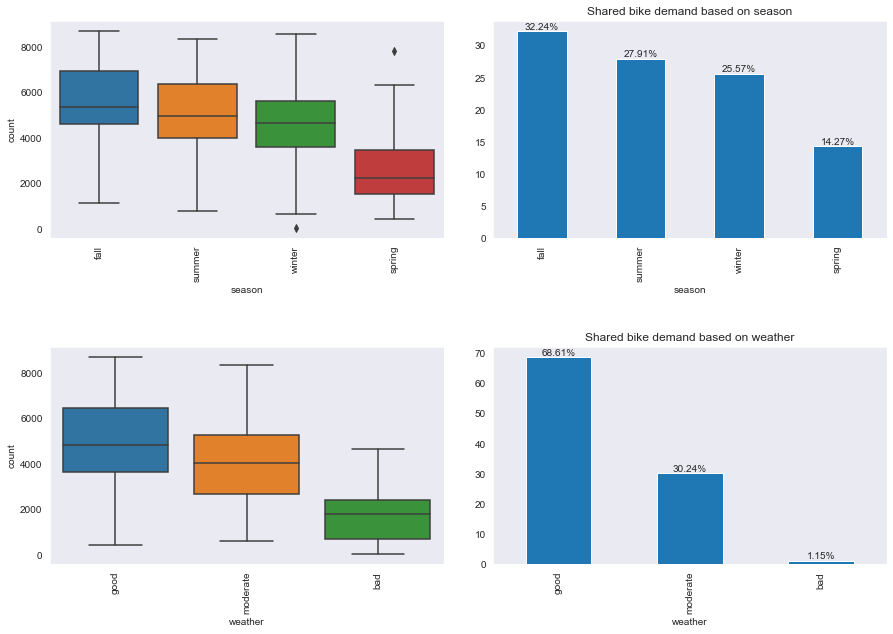

In [421]:
# visualising the categorical variables season and weather against count
xVars=['season','weather']
categoricalBoxPlots(xVars,y='count',data=bikesharing)

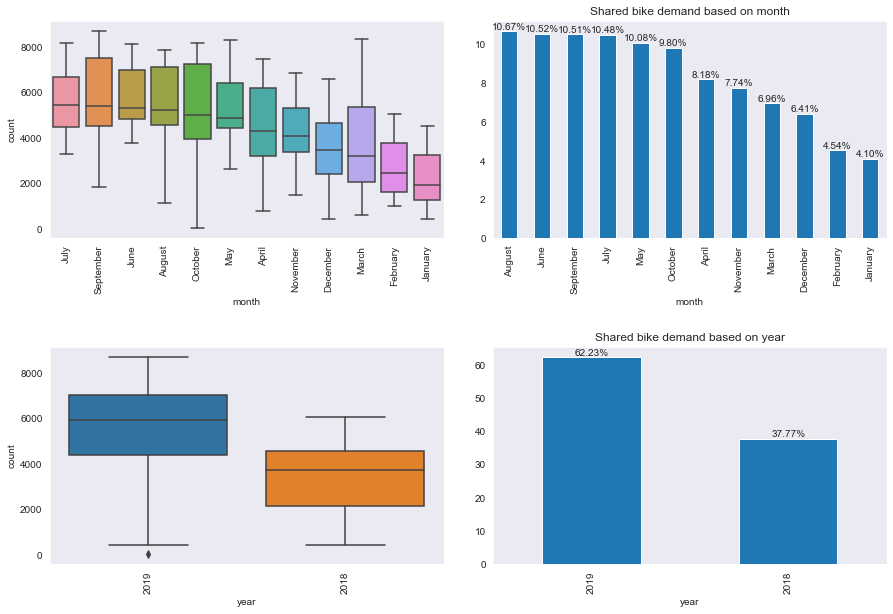

In [422]:
# visualising the categorical variables month and year against count
xVars=['month','year']
categoricalBoxPlots(xVars,y='count',data=bikesharing)

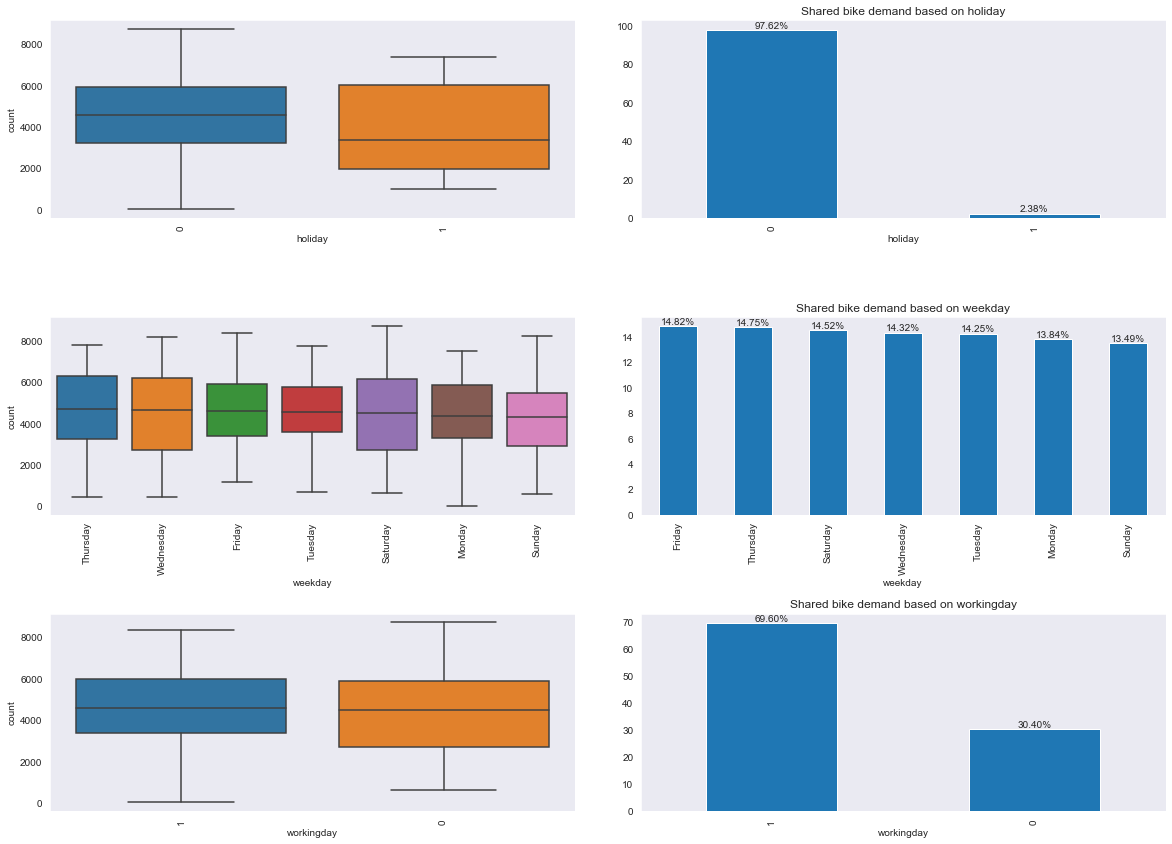

In [423]:
# visualising the categorical variables holiday, weekday and workingday against count
xVars=['holiday','weekday','workingday']
categoricalBoxPlots(xVars,y='count',data=bikesharing)

### Observation:
     
* season: Almost 32% of the bike booking were happening in fall with a median of over 5000 booking (for the period of 2 years). This was followed by summer & winter with 28% & 26% of total booking. This indicates, season can be a good predictor for the dependent variable.

* month: Almost 10% of the bike booking were happening in the months August, June, September, July and May  with a median of over 4000 booking per month. This indicates, month has some trend for bookings and can be a good predictor for the dependent variable.

* weather: Almost 68% of the bike booking were happening during clear or partly cloudy with a median of close to 5000 booking (for the period of 2 years). This was followed by Mist and cloudy with 30% of total booking. This indicates, weather does show some trend towards the bike bookings can be a good predictor for the dependent variable.

* holiday: Almost 98% of the bike booking were happening when it is not a holiday which means this data is clearly biased. This indicates, holiday CANNOT be a good predictor for the dependent variable.

* weekday: weekday variable shows very close trend (between 13.5%-14.8% of total booking on all days of the week) having their independent medians between 4000 to 5000 bookings. This variable can have some or no influence towards the predictor. We will let the model decide if this needs to be added or not during RFE.

* workingday: Almost 69% of the bike booking were happening on a workingday with a median of close to 5000 booking (for the period of 2 years). This indicates, workingday can be a good predictor for the dependent variable.

* year: this shows almost 25% increase in the bike bookings from 2018 to 2019. Due to pandemic, the sales might have dropped but this trend indicates that post covid the sales will increase year on year. Again we will let model decide if this is signficant during RFE. 

### 2.2 Visualising the numeric variables


<Figure size 1080x720 with 0 Axes>

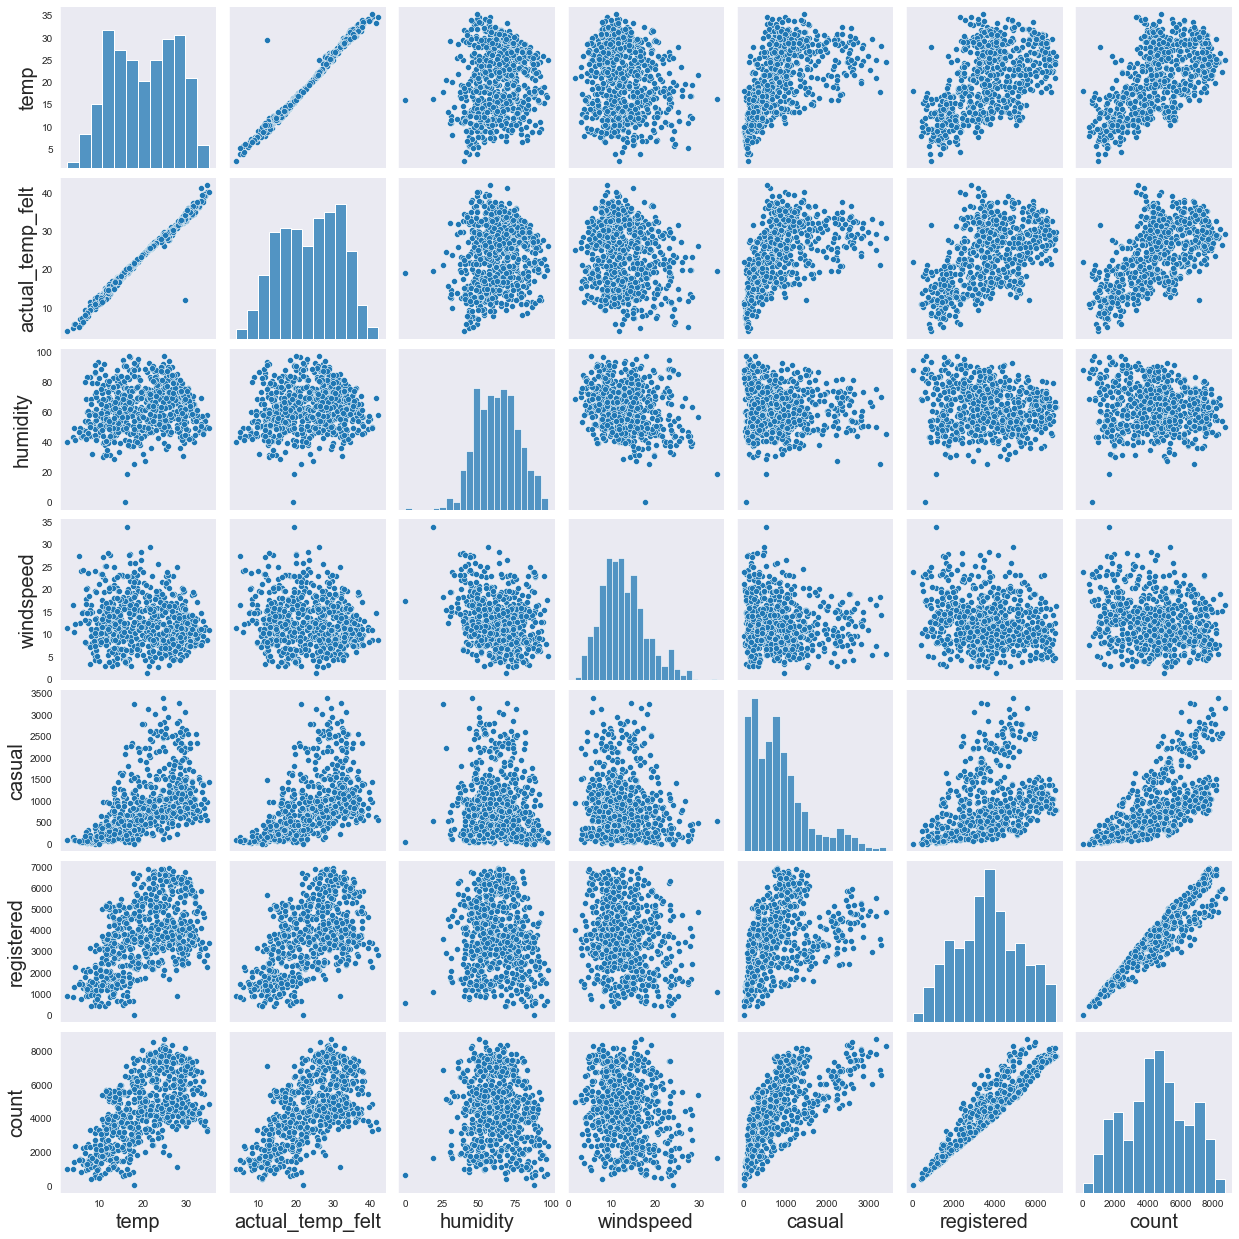

In [424]:
plt.figure(figsize = (15,10))
with sns.plotting_context(rc={"axes.labelsize":20}):
    sns.pairplot(bikesharing)
plt.show()

#### Observation:

    - temp and actual_temp_felt are highly correlated. Hence we can drop one of the columns
    - count is linearly correlated with registered column. The registered and casual will be part of count 
      and will be dropped during RFE
    - count doesn't seem to correlate well with humidity and windspeed
    - count doesn't seem to correlate well with the day as well.
    
    We can plot the correlation matrix and re-affirm these observations before further processing.

#### 2.3 Correlation Matrix

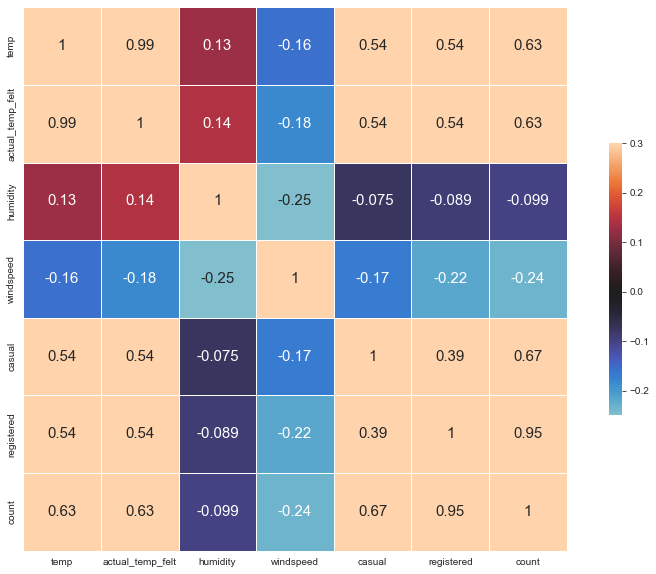

In [425]:
plt.figure(figsize = (15,10))
mask = np.zeros_like(bikesharing.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(bikesharing.corr(), vmax=.3, center=0,annot=True,annot_kws={'size':15},
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

#### Observation:

    - temp and actual_temp_felt have a correlation of 0.99 and confirms our observation as seen in pairplot. 
      Hence we can drop one of the columns
    - count and registered columns have correlation of 0.95. The registered and casual will be part of count 
      and will be dropped during RFE
    - count is not well correlated with humidity. This might not contribute in predicting the count
    - count is negatively correlated with windspeed
    - count is again not correlated well with the day and is not a significant variable.

#### 2.4 Let us look at the various distribution 

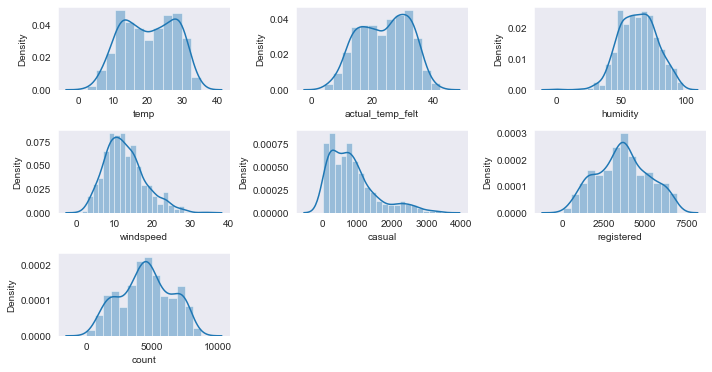

In [426]:
fig = plt.subplots(figsize=(10,10))

for i,j in enumerate(['temp','actual_temp_felt','humidity','windspeed','casual','registered','count']):
    plt.subplot(6,3,i+1)
    plt.subplots_adjust(hspace=1.0)
    sns.distplot(bikesharing[j])
    plt.tight_layout()

#### Observation:
    - temp and actual_temp_felt have almost similar distribution
    - humidity is mostly between 50-75
    - windspeed is mostly between 8-12
    - registered and count have similar distribution as majority of the bike users are registered users.

#### Let us also confirm that count of registered user and casual users matches with the count

In [427]:
bikesharing[~(bikesharing['registered'] + bikesharing['casual']==bikesharing['count'])].shape

(0, 14)

- We can notice that the registered and casual = count and there are no rows violating this in the dataset.
  Hence regisetered and casual can be dropped.

In [428]:
# To avoid data leakage and as count = registered + casual, let us drop registered and casuals
bikesharing.drop(["registered","casual"],axis=1,inplace=True)
bikesharing.head()

,season,year,month,holiday,weekday,workingday,weather,temp,actual_temp_felt,humidity,windspeed,count
0,spring,2018,January,0,Saturday,0,moderate,14.110847,18.18125,80.5833,10.749882,985
1,spring,2018,January,0,Sunday,0,moderate,14.902598,17.68695,69.6087,16.652113,801
2,spring,2018,January,0,Monday,1,good,8.050924,9.47025,43.7273,16.636703,1349
3,spring,2018,January,0,Tuesday,1,good,8.200000,10.60610,59.0435,10.739832,1562
4,spring,2018,January,0,Wednesday,1,good,9.305237,11.46350,43.6957,12.522300,1600


#### QQ plot

[Text(0.5, 1.0, 'Theoritical quantiles')]

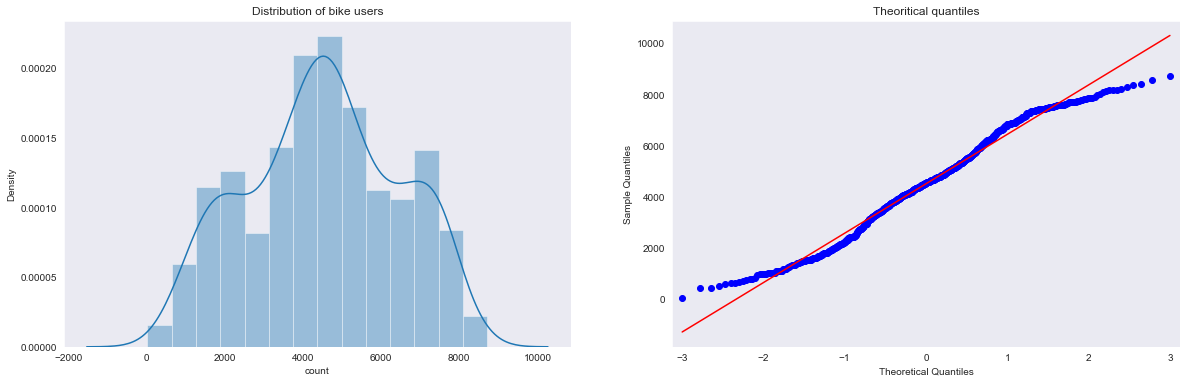

In [429]:
fig, (ax1,ax2) = plt.subplots(ncols=2,figsize=(20,6))
sns.distplot(bikesharing['count'],ax=ax1)
ax1.set(title='Distribution of bike users')
qqplot(bikesharing['count'],ax=ax2,line='s')
ax2.set(title='Theoritical quantiles')

#### Observation:
   - The count is normally distributed.
   - All the values in the dataset nicely fit on the line. 
     So no additional processing required for count variable like converting to logarithimic scale etc..

## Step 3: Data Preparation for Linear regression

- You can see that the dataset has many columns with categorical values.

- But in order to fit a regression line, we would need numerical values and not string. Hence, we need to convert them to 1s and 0s.

- Encoding:
  converting binary categorical variables to 1 and 0
  Other categorical variables to dummy variables
  
- split into train and test
- rescaling of the variables

### Dummy Variables

#### Encoding the categorical variables

Month shows very strong trend for the demands.

In [430]:
bikesharing["year"]=bikesharing["year"].apply(lambda year:1 if year=="2019" else 0)

In [431]:
bikesharing = pd.get_dummies(data=bikesharing,columns=["month","season","weekday"],drop_first=True)
bikesharing = pd.get_dummies(data=bikesharing,columns=["weather"])

In [432]:
# dropping the season,weekday and weather columns as they are not needed now
bikesharing.head()

,year,holiday,workingday,temp,actual_temp_felt,humidity,windspeed,count,month_February,month_March,month_April,month_May,month_June,month_July,month_August,month_September,month_October,month_November,month_December,season_summer,season_fall,season_winter,weekday_Monday,weekday_Tuesday,weekday_Wednesday,weekday_Thursday,weekday_Friday,weekday_Saturday,weather_good,weather_moderate,weather_bad
0,0,0,0,14.110847,18.18125,80.5833,10.749882,985,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
1,0,0,0,14.902598,17.68695,69.6087,16.652113,801,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,0,1,8.050924,9.47025,43.7273,16.636703,1349,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
3,0,0,1,8.200000,10.60610,59.0435,10.739832,1562,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
4,0,0,1,9.305237,11.46350,43.6957,12.522300,1600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0


## Step 4: Splitting the Data into Training and Testing Sets and scaling

As you know, the first basic step for regression is performing a train-test split.


In [433]:
bikesharing_train, bikesharing_test= train_test_split(bikesharing,train_size=0.7,random_state=100)
print(bikesharing_train.shape)
print(bikesharing_test.shape)

(510, 31)
(220, 31)


### Rescaling the Features 

It is extremely important to rescale the variables so that they have a comparable scale. If we don't have comparable scales, then some of the coefficients as obtained by fitting the regression model might be very large or very small as compared to the other coefficients. This might become very annoying at the time of model evaluation. So it is advised to use standardization or normalization so that the units of the coefficients obtained are all on the same scale. As you know, there are two common ways of rescaling:

1. Min-Max scaling (normalization)
2. Standardisation (mean-0, sigma-1) 

This time, we will use MinMax scaling.

normalization = (x-xmin)/(xmax-xmin)
standardization= (x-m)/sigma

fit(): learns xmin,xmax
transform(): (x-xmin)/(xmax-xmin)

fit_transform():

### Question: Should the target variable be scaled??

A target variable with a large spread of values, in turn, may result in large error gradient values causing weight values to change dramatically, making the learning process unstable.

Reference: https://stats.stackexchange.com/questions/111467/is-it-necessary-to-scale-the-target-value-in-addition-to-scaling-features-for-re#:~:text=Yes%2C%20you%20do%20need%20to,making%20the%20learning%20process%20unstable.

In [434]:
# Instantiate an object
scaler = MinMaxScaler()
# create a list of numeric variables
num_vars = ['count','temp','actual_temp_felt','humidity','windspeed']
# Fit on data
bikesharing_train[num_vars]=scaler.fit_transform(bikesharing_train[num_vars])
bikesharing_train.head()

,year,holiday,workingday,temp,actual_temp_felt,humidity,windspeed,count,month_February,month_March,month_April,month_May,month_June,month_July,month_August,month_September,month_October,month_November,month_December,season_summer,season_fall,season_winter,weekday_Monday,weekday_Tuesday,weekday_Wednesday,weekday_Thursday,weekday_Friday,weekday_Saturday,weather_good,weather_moderate,weather_bad
576,1,0,1,0.815169,0.766351,0.725633,0.264686,0.827658,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0
426,1,0,0,0.442393,0.438975,0.640189,0.255342,0.465255,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
728,1,0,0,0.245101,0.200348,0.498067,0.663106,0.204096,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
482,1,0,0,0.395666,0.391735,0.504508,0.188475,0.482973,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0
111,0,0,1,0.345824,0.318819,0.751824,0.380981,0.191095,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0


In [435]:
#Inspect stats fro Training set after scaling
bikesharing_train.describe()

,year,temp,actual_temp_felt,humidity,windspeed,count,month_February,month_March,month_April,month_May,month_June,month_July,month_August,month_September,month_October,month_November,month_December,season_summer,season_fall,season_winter,weekday_Monday,weekday_Tuesday,weekday_Wednesday,weekday_Thursday,weekday_Friday,weekday_Saturday,weather_good,weather_moderate,weather_bad
count,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000
mean,0.507843,0.537440,0.513156,0.650480,0.320883,0.513499,0.066667,0.098039,0.078431,0.084314,0.076471,0.076471,0.096078,0.080392,0.084314,0.086275,0.084314,0.247059,0.262745,0.247059,0.150980,0.131373,0.158824,0.133333,0.127451,0.154902,0.625490,0.345098,0.029412
std,0.500429,0.225858,0.212410,0.145846,0.169803,0.224421,0.249689,0.297660,0.269113,0.278131,0.266010,0.266010,0.294988,0.272166,0.278131,0.281045,0.278131,0.431725,0.440557,0.431725,0.358381,0.338139,0.365870,0.340268,0.333805,0.362166,0.484471,0.475867,0.169124
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.339853,0.332086,0.538643,0.199179,0.356420,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.542596,0.529718,0.653714,0.296763,0.518638,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,1.000000,0.735215,0.688457,0.754830,0.414447,0.684710,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


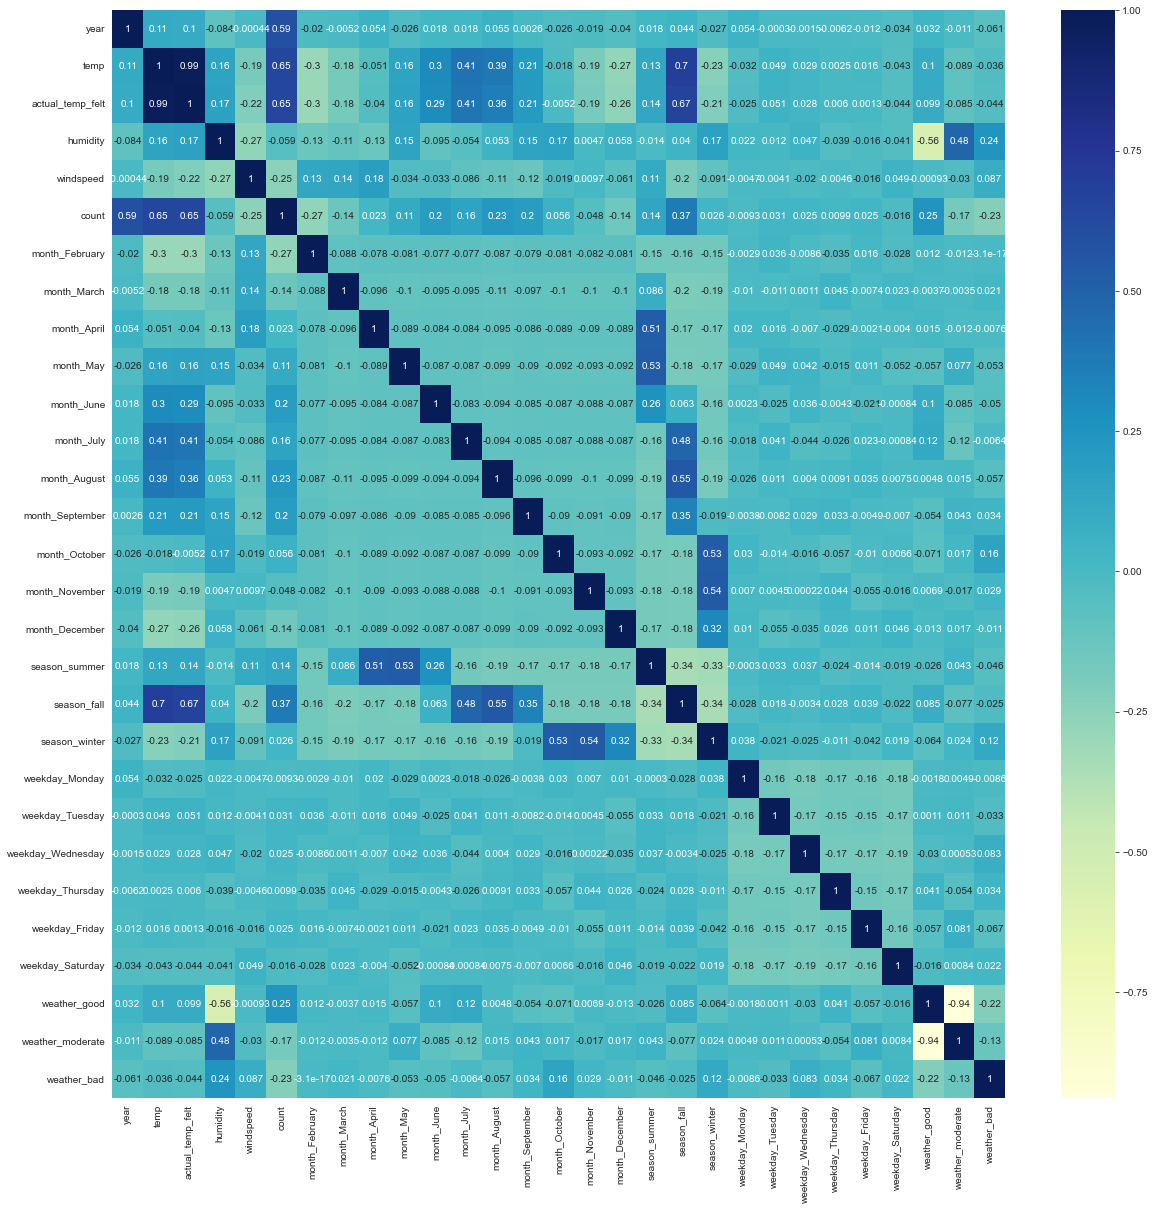

In [436]:
# correlation matrix
plt.figure(figsize = (20,20))
sns.heatmap(bikesharing_train.corr(), annot = True, cmap='YlGnBu')
plt.show()

In [437]:
bikesharing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 31 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   year               730 non-null    int64   
 1   holiday            730 non-null    category
 2   workingday         730 non-null    category
 3   temp               730 non-null    float64 
 4   actual_temp_felt   730 non-null    float64 
 5   humidity           730 non-null    float64 
 6   windspeed          730 non-null    float64 
 7   count              730 non-null    int64   
 8   month_February     730 non-null    uint8   
 9   month_March        730 non-null    uint8   
 10  month_April        730 non-null    uint8   
 11  month_May          730 non-null    uint8   
 12  month_June         730 non-null    uint8   
 13  month_July         730 non-null    uint8   
 14  month_August       730 non-null    uint8   
 15  month_September    730 non-null    uint8   
 16  month_Oc

### Dividing into X and y sets for the model building

In [438]:
y_train = bikesharing_train.pop('count')
X_train = bikesharing_train

## Building the model using Hybrid approach i.e RFE and further removing the variables manually

We will be using the **LinearRegression function from SciKit Learn** for its compatibility with RFE (which is a utility from sklearn)

In [439]:
def build_model(features):
    X_train_sm = sm.add_constant(X_train[features])
    lm = sm.OLS(y_train, X_train_sm).fit()
    print(lm.summary())
    return X_train_sm,lm

In [440]:
def calculate_VIF(features):
    df1 = X_train[features]
    vif = pd.DataFrame()
    vif['Features'] = df1.columns
    vif['VIF'] = [variance_inflation_factor(df1.values, i) for i in range(df1.shape[1])]
    vif['VIF'] = round(vif['VIF'],2)
    print(vif.sort_values(by='VIF',ascending=False))

#### Model1 - Include all features 

In [441]:
features = X_train.columns
X_train_lm,lr_model = build_model(features)
calculate_VIF(features)

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     99.37
Date:                Wed, 09 Feb 2022   Prob (F-statistic):          2.81e-180
Time:                        14:45:42   Log-Likelihood:                 527.12
No. Observations:                 510   AIC:                            -996.2
Df Residuals:                     481   BIC:                            -873.4
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0533      0.02

### RFE
Recursive feature elimination

In [442]:
# Running RFE with the output number of the variable equal to 15
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, 15)             # running RFE
rfe = rfe.fit(X_train, y_train)

In [443]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('year', True, 1),
 ('holiday', True, 1),
 ('workingday', True, 1),
 ('temp', True, 1),
 ('actual_temp_felt', False, 7),
 ('humidity', True, 1),
 ('windspeed', True, 1),
 ('month_February', False, 8),
 ('month_March', False, 3),
 ('month_April', False, 5),
 ('month_May', False, 4),
 ('month_June', False, 6),
 ('month_July', False, 9),
 ('month_August', True, 1),
 ('month_September', True, 1),
 ('month_October', True, 1),
 ('month_November', False, 10),
 ('month_December', False, 11),
 ('season_summer', True, 1),
 ('season_fall', False, 2),
 ('season_winter', True, 1),
 ('weekday_Monday', False, 12),
 ('weekday_Tuesday', False, 13),
 ('weekday_Wednesday', False, 15),
 ('weekday_Thursday', False, 16),
 ('weekday_Friday', False, 14),
 ('weekday_Saturday', True, 1),
 ('weather_good', True, 1),
 ('weather_moderate', True, 1),
 ('weather_bad', True, 1)]

In [444]:
features = X_train.columns[rfe.support_]
features

Index(['year', 'holiday', 'workingday', 'temp', 'humidity', 'windspeed',
       'month_August', 'month_September', 'month_October', 'season_summer',
       'season_winter', 'weekday_Saturday', 'weather_good', 'weather_moderate',
       'weather_bad'],
      dtype='object')

In [445]:
X_train.columns[~rfe.support_]

Index(['actual_temp_felt', 'month_February', 'month_March', 'month_April',
       'month_May', 'month_June', 'month_July', 'month_November',
       'month_December', 'season_fall', 'weekday_Monday', 'weekday_Tuesday',
       'weekday_Wednesday', 'weekday_Thursday', 'weekday_Friday'],
      dtype='object')

### Model 2 - Build with features supported by RFE

In [446]:
X_train_lm,lr_model = build_model(features)
calculate_VIF(features)

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     196.6
Date:                Wed, 09 Feb 2022   Prob (F-statistic):          8.70e-192
Time:                        14:45:42   Log-Likelihood:                 518.52
No. Observations:                 510   AIC:                            -1007.
Df Residuals:                     495   BIC:                            -943.5
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0701      0.025  

### Observation:
   - All the p values are < 0.05, we can look at the correlation matrix and weather_moderate and high VIF and low correlation with count when compared to weather_good. Let us drop weather_moderate. We will be following a similar approach for each model

### Model 3

In [447]:
features = features.drop('weather_moderate')
X_train_lm,lr_model = build_model(features)
calculate_VIF(features)

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     196.6
Date:                Wed, 09 Feb 2022   Prob (F-statistic):          8.70e-192
Time:                        14:45:42   Log-Likelihood:                 518.52
No. Observations:                 510   AIC:                            -1007.
Df Residuals:                     495   BIC:                            -943.5
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.1380      0.034  

### Model 4

In [448]:
features = features.drop('humidity')
X_train_lm,lr_model = build_model(features)
calculate_VIF(features)

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     201.8
Date:                Wed, 09 Feb 2022   Prob (F-statistic):          1.97e-188
Time:                        14:45:42   Log-Likelihood:                 507.76
No. Observations:                 510   AIC:                            -987.5
Df Residuals:                     496   BIC:                            -928.2
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0097      0.019  

### Model 5

In [449]:
features = features.drop('month_October')
X_train_lm,lr_model = build_model(features)
calculate_VIF(features)

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     217.0
Date:                Wed, 09 Feb 2022   Prob (F-statistic):          8.64e-189
Time:                        14:45:42   Log-Likelihood:                 505.81
No. Observations:                 510   AIC:                            -985.6
Df Residuals:                     497   BIC:                            -930.6
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0072      0.019  

### Model 6

In [450]:
features = features.drop('holiday')
X_train_lm,lr_model = build_model(features)
calculate_VIF(features)

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     234.9
Date:                Wed, 09 Feb 2022   Prob (F-statistic):          4.31e-189
Time:                        14:45:42   Log-Likelihood:                 503.70
No. Observations:                 510   AIC:                            -983.4
Df Residuals:                     498   BIC:                            -932.6
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.0016      0.019  

### Observation:
   - All p values are < 0.05 and only VIF for temp is 6.95 which indicates that temp is represented by other variables and is correlated.
   - So let us find the feature that is best correlated with temp.

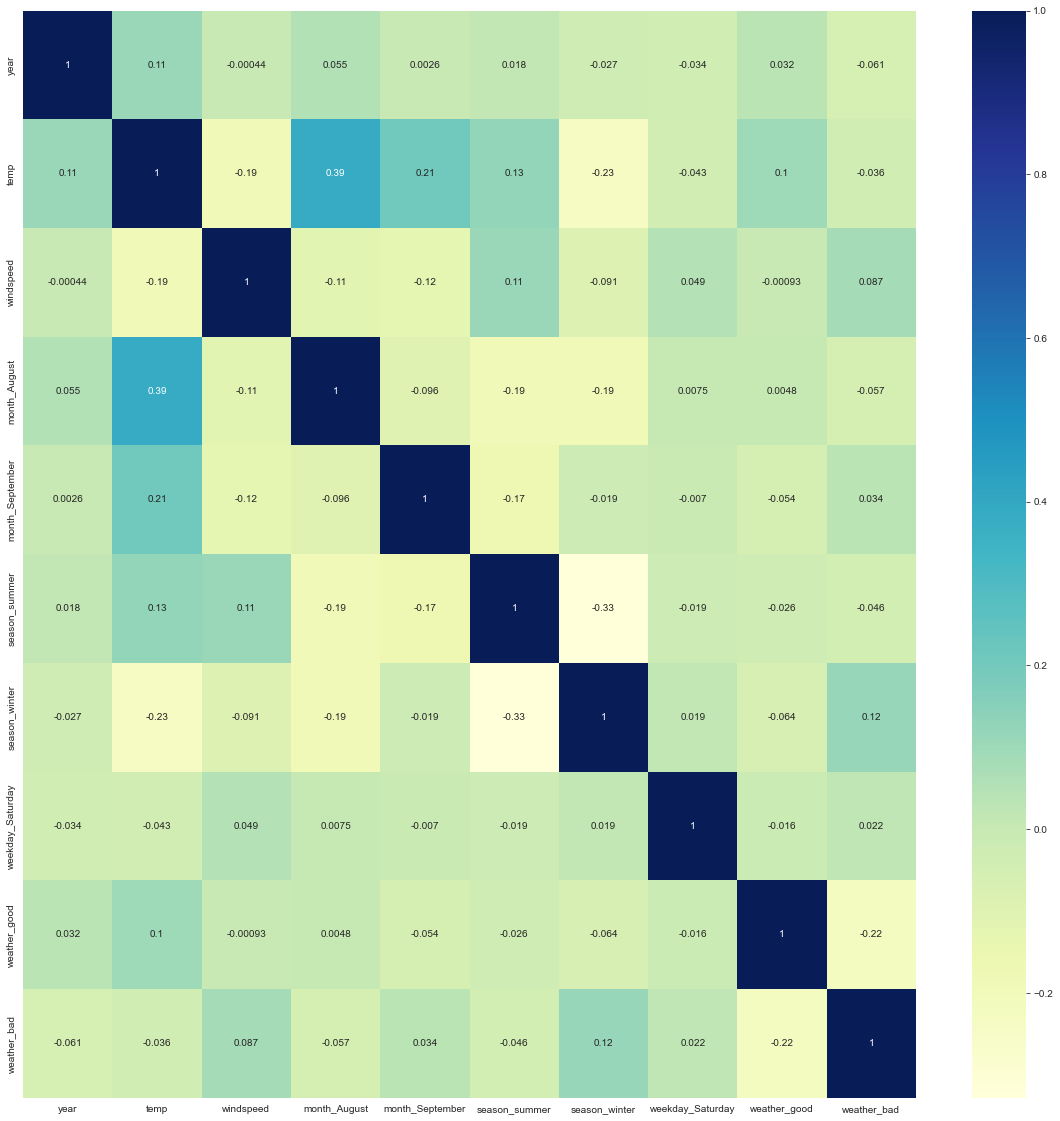

In [451]:
plt.figure(figsize = (20,20))
sns.heatmap(bikesharing_train[features].corr(), annot = True, cmap='YlGnBu')
plt.show()

   - month_August is highly correlated with temp and hence we can drop this feature in next model

### Model 7

In [452]:
features = features.drop('month_August')
X_train_lm,lr_model = build_model(features)
calculate_VIF(features)

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     253.0
Date:                Wed, 09 Feb 2022   Prob (F-statistic):          3.13e-188
Time:                        14:45:43   Log-Likelihood:                 498.79
No. Observations:                 510   AIC:                            -975.6
Df Residuals:                     499   BIC:                            -929.0
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.0050      0.019  

### Model 8

In [453]:
features = features.drop('temp')
build_model(features)
calculate_VIF(features)

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.579
Model:                            OLS   Adj. R-squared:                  0.571
Method:                 Least Squares   F-statistic:                     76.41
Date:                Wed, 09 Feb 2022   Prob (F-statistic):           3.79e-88
Time:                        14:45:43   Log-Likelihood:                 259.52
No. Observations:                 510   AIC:                            -499.0
Df Residuals:                     500   BIC:                            -456.7
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.2965      0.025  

### Observation:

   - Even though the p < 0.05 and VIF < 5 for all the features, the adj-R^2 dropped from 0.83 to 0.64. Hence we cannot drop temp feature.
   - Let us re-add the feature.

In [454]:
features = features.union(['temp'])
build_model(features)
calculate_VIF(features)

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     253.0
Date:                Wed, 09 Feb 2022   Prob (F-statistic):          3.13e-188
Time:                        14:45:43   Log-Likelihood:                 498.79
No. Observations:                 510   AIC:                            -975.6
Df Residuals:                     499   BIC:                            -929.0
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.0050      0.019  

### Model 9

In [455]:
features = features.drop(['workingday'])
X_train_lm,lr_model = build_model(features)
calculate_VIF(features)

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.827
Model:                            OLS   Adj. R-squared:                  0.824
Method:                 Least Squares   F-statistic:                     265.5
Date:                Wed, 09 Feb 2022   Prob (F-statistic):          3.99e-184
Time:                        14:45:43   Log-Likelihood:                 486.20
No. Observations:                 510   AIC:                            -952.4
Df Residuals:                     500   BIC:                            -910.1
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0406      0.017  

### Model 10

In [456]:
features = features.drop(['weekday_Saturday'])
X_train_lm,lr_model = build_model(features)
calculate_VIF(features)

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.826
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     296.5
Date:                Wed, 09 Feb 2022   Prob (F-statistic):          1.53e-184
Time:                        14:45:43   Log-Likelihood:                 484.24
No. Observations:                 510   AIC:                            -950.5
Df Residuals:                     501   BIC:                            -912.4
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0442      0.017     

### Observation :

   - Since all p values are < 0.05 and VIF for all features are less than 5,
     and Adj-R^2 is 0.823, Model 10 can be our final model.
   - F statistic is high and Prob (F-statistic) is ~ 0 and all coefficients are non zero  
     Hence we can infer that the model is significant.

### Model 10

### Final Model coefficients

In [457]:
lr_model.params

const              0.044248
month_September    0.097843
season_summer      0.089399
season_winter      0.128144
temp               0.552655
weather_bad       -0.201859
weather_good       0.076670
windspeed         -0.155224
year               0.233163
dtype: float64

#### Model Interpretation

   y = B0 + B1X1 + B2X2 ...BnXn

   y = (const * 0.044248) + (temp * 0.552655) + (year * 0.233163) + (season_Winter * 0.128144) +
       (month_September * 0.097843) + (season_Summer * 0.089399) + (weather_good * 0.076670)  
       -(windspeed * 0.155224) -(weather_bad * 0.201859)

   Variables : 

         1) temp, year, season_Winter, month_September, season_Summer and weather_good have positive impact on bike 
            rental. 1 unit increase in variables will increase the bookings.
         2) windspeed and weather_bad have negative impact on bike rental. 1 unit increase in variables 
            will decrease the bookings.



## Model Evaluation

### Residual Analysis of the train data

Text(0.5, 0, 'Errors')

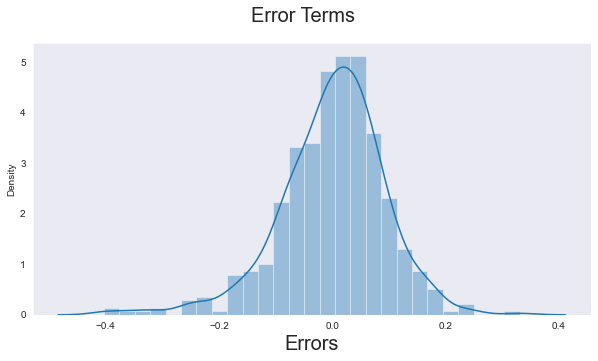

In [458]:
y_train_pred = lr_model.predict(X_train_lm)
res = y_train - y_train_pred
fig = plt.figure(figsize=(10,5))
sns.distplot(res)
fig.suptitle('Error Terms', fontsize=20)
plt.xlabel('Errors',fontsize=20)

#### Errors are normally distribured with mean 0  and are normally distributed

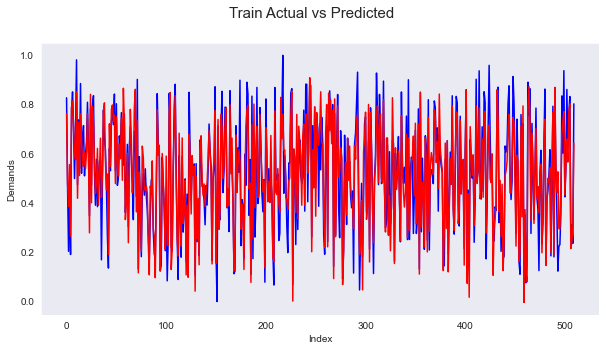

In [459]:
# Actual vs Predicted
fig = plt.figure(figsize=(10,5))
c = [i for i in range(0,len(X_train),1)]
plt.plot(c,y_train, color="blue")
plt.plot(c,y_train_pred, color="red")
plt.suptitle('Train Actual vs Predicted', fontsize = 15)
plt.xlabel('Index', fontsize=10)
plt.ylabel('Demands', fontsize=10)
plt.show()

 ####  Actual and predicted values are almost following the same pattern on trained set. So model looks good.

#### Linearity Check

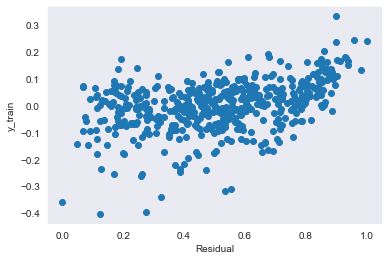

In [460]:
# Error Terms
plt.scatter(y_train,res)
plt.ylabel("y_train")
plt.xlabel("Residual")
plt.show()

#### We can observe that the error is randomly distributed and independent of each other.

#### Predict values for test data set

In [461]:
#Scale variables in X_test
num_vars = ['count','temp','actual_temp_felt','humidity','windspeed']

#Test data to be transformed only, no fitting
bikesharing_test[num_vars] = scaler.transform(bikesharing_test[num_vars])
bikesharing.head()

,year,holiday,workingday,temp,actual_temp_felt,humidity,windspeed,count,month_February,month_March,month_April,month_May,month_June,month_July,month_August,month_September,month_October,month_November,month_December,season_summer,season_fall,season_winter,weekday_Monday,weekday_Tuesday,weekday_Wednesday,weekday_Thursday,weekday_Friday,weekday_Saturday,weather_good,weather_moderate,weather_bad
0,0,0,0,14.110847,18.18125,80.5833,10.749882,985,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
1,0,0,0,14.902598,17.68695,69.6087,16.652113,801,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,0,1,8.050924,9.47025,43.7273,16.636703,1349,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
3,0,0,1,8.200000,10.60610,59.0435,10.739832,1562,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
4,0,0,1,9.305237,11.46350,43.6957,12.522300,1600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0


In [462]:
y_test = bikesharing_test.pop('count')
X_test = bikesharing_test

In [463]:
X_test_new = X_test[features]
X_test_new = sm.add_constant(X_test_new)
X_test_new.head()

,const,month_September,season_summer,season_winter,temp,weather_bad,weather_good,windspeed,year
184,1.0,0,0,0,0.831783,0,0,0.084219,0
535,1.0,0,1,0,0.901354,0,1,0.153728,1
299,1.0,0,0,1,0.511964,0,0,0.334206,0
221,1.0,0,0,0,0.881625,0,1,0.339570,0
152,1.0,0,1,0,0.817246,0,1,0.537414,0


#### Predict on the test model

In [464]:
y_test_pred = lr_model.predict(X_test_new)

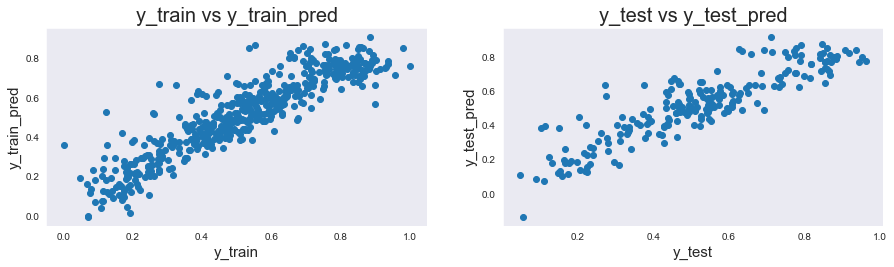

In [465]:
plt.figure(figsize=(15,8))
#sns.set_style("dark")
# subplot 1
plt.subplot(2, 2, 1)
ax = plt.scatter(y_train,y_train_pred)
plt.title('y_train vs y_train_pred',fontsize=20)
plt.xlabel('y_train',fontsize=15)
plt.ylabel('y_train_pred',fontsize=15)
# subplot 2
plt.subplot(2, 2, 2)
ax1 = plt.scatter(y_test,y_test_pred)
plt.title('y_test vs y_test_pred',fontsize=20)
plt.xlabel('y_test',fontsize=15)
plt.ylabel('y_test_pred',fontsize=15)
plt.show()

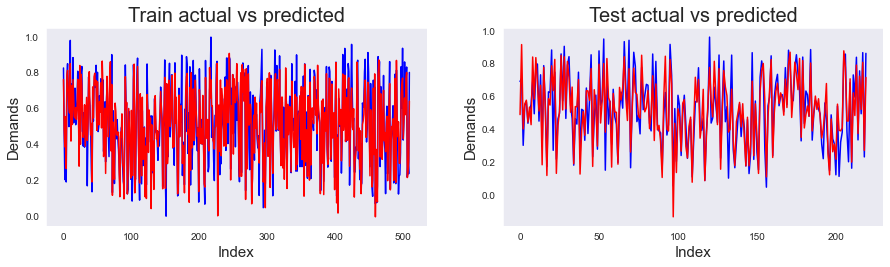

In [466]:
plt.figure(figsize=(15,8))
#sns.set_style("dark")
# subplot 1
plt.subplot(2, 2, 1)
c = [i for i in range(0,len(X_train),1)]
plt.plot(c,y_train, color="blue")
plt.plot(c,y_train_pred, color="red")
plt.title('Train actual vs predicted',fontsize=20)
plt.xlabel('Index',fontsize=15)
plt.ylabel('Demands',fontsize=15)
# subplot 2
plt.subplot(2, 2, 2)
c = [i for i in range(0,len(X_test_new),1)]
plt.plot(c,y_test, color="blue")
plt.plot(c,y_test_pred, color="red")
plt.title('Test actual vs predicted',fontsize=20)
plt.xlabel('Index',fontsize=15)
plt.ylabel('Demands',fontsize=15)
plt.show()

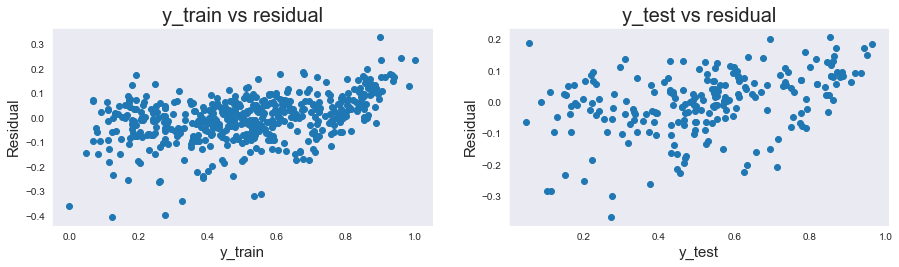

In [467]:
plt.figure(figsize=(15,8))
#sns.set_style("dark")
# subplot 1
plt.subplot(2, 2, 1)
plt.scatter(y_train,y_train-y_train_pred)
plt.title('y_train vs residual',fontsize=20)
plt.xlabel('y_train',fontsize=15)
plt.ylabel('Residual',fontsize=15)
# subplot 2
plt.subplot(2, 2, 2)
plt.scatter(y_test,y_test-y_test_pred)
plt.title('y_test vs residual',fontsize=20)
plt.xlabel('y_test',fontsize=15)
plt.ylabel('Residual',fontsize=15)
plt.show()

In [468]:
print("Train Mean Square Error : " , mean_squared_error(y_true=y_train,y_pred=y_train_pred))
print("Test Mean Square Error  : " , mean_squared_error(y_true=y_test,y_pred=y_test_pred))

Train Mean Square Error :  0.00876616744122608
Test Mean Square Error  :  0.010003617157092344


In [469]:
print("Train R2 Square : " , r2_score(y_true=y_train,y_pred=y_train_pred))
print("Test R2 Square  : " , r2_score(y_true=y_test,y_pred=y_test_pred))

Train R2 Square :  0.825604317961911
Test R2 Square  :  0.7907818070220924


#### Summary

Based on analysis below inputs can help company to expand the business

1) As covid cases are decreasing the demand is expectdd to increase on year basis.
   This is based on the 2 year data trend we saw

2) Company should focus on expanding business during September,Summer and Winter Season. 

3) When temp is high the demand increases, the company should check the temp and can plan to accomodate the 
   requirements.
   
4) There would be less bookings during Light Snow or Rain, they could probably use this time to serive the bikes 
   without having business impact.
   
   Hence when the situation comes back to normal post covid, the company should come up with new offers during spring 
   when the weather is pleasant and also advertise a little for September as this is when business would be at its 
   best.
